# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**:

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("local[*]") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/26 13:59:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [17]:
# Build schema
from diego_orozco.spark_utils import SparkUtils
# Import your module

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])

df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")
#df_agencies.show(truncate=False)


In [18]:
from pyspark.sql.functions import get_json_object

df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, '$.agency_name'))
df_agencies=df_agencies.drop("agency_info")

In [24]:
# Build schema
from diego_orozco.spark_utils import SparkUtils
# Import your module

schema_brands = SparkUtils.generate_schema([("brands_id", "int"), ("brands_info", "string")])

df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")


In [26]:
from pyspark.sql.functions import get_json_object

df_brands = df_brands.withColumn("brand_name", get_json_object(df_brands.brands_info, '$.brand_name'))
df_brands = df_brands.drop("brands_info")

In [27]:
# Build schema
from diego_orozco.spark_utils import SparkUtils
# Import your module

schema_cars = SparkUtils.generate_schema([("cars_id", "int"), ("cars_info", "string")])

df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")


In [28]:
from pyspark.sql.functions import get_json_object

df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.cars_info, '$.car_name'))
df_cars=df_cars.drop("cars_info")

In [29]:
# Build schema
from diego_orozco.spark_utils import SparkUtils
# Import your module

schema_customers = SparkUtils.generate_schema([("customers_id", "int"), ("customers_info", "string")])

df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")


In [30]:
from pyspark.sql.functions import get_json_object

df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customers_info, '$.customer_name'))
df_customers=df_customers.drop("customers_info")

In [32]:
# Build schema
from diego_orozco.spark_utils import SparkUtils
# Import your module

schema_rentals = SparkUtils.generate_schema([("rentals_id", "int"), ("rentals_info", "string")])

df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")


In [33]:
from pyspark.sql.functions import get_json_object

df_rentals = df_rentals.withColumn("car_id", get_json_object(df_rentals.rentals_info, '$.car_id'))
df_rentals = df_rentals.withColumn("customer_id", get_json_object(df_rentals.rentals_info, '$.customer_id'))
df_rentals = df_rentals.withColumn("agency_id", get_json_object(df_rentals.rentals_info, '$.agency_id'))
df_rentals=df_rentals.drop("rentals_info")

In [34]:
result = df_rentals.join(df_agencies, on="agency_id", how="left")
result = result.join(df_customers, result["customer_id"]==df_customers["customers_id"], how="left")
result = result.join(df_cars, result["car_id"]==df_cars["cars_id"], how="left")

result=result.drop("agency_id","customer_id","customers_id","car_id", "cars_id")


In [35]:
result.show()

+----------+-------------+---------------+--------------------+
|rentals_id|  agency_name|  customer_name|            car_name|
+----------+-------------+---------------+--------------------+
|     11891|  NYC Rentals| Margaret Jones|Wallace-Carlson M...|
|     11892|LA Car Rental|Albert Williams|Grimes-Green Model 8|
|     11893|      SF Cars|  Caleb Fleming|Stewart-Allen Mod...|
|     11894|  NYC Rentals|  Andrew Butler|  Campos PLC Model 4|
|     11895|      SF Cars|  Kristin Potts|  Wagner LLC Model 1|
|     11896|LA Car Rental|   Jeremy Parks|Jones, Jefferson ...|
|     11897| Zapopan Auto|    Terry Wells|Lopez and Sons Mo...|
|     11898|      SF Cars|  Marc Williams| Salazar Ltd Model 8|
|     11899|LA Car Rental| Danny Williams|Villanueva PLC Mo...|
|     11900|      SF Cars| Eric Owens PhD|Faulkner-Howard M...|
|     11901|  NYC Rentals|    Laura Perry|Faulkner-Howard M...|
|     11902|  NYC Rentals|     Paul Brown|Faulkner-Howard M...|
|     11903| Zapopan Auto|Alexa Hernande

In [36]:
!pwd

/opt/spark/work-dir


In [37]:
!du -sh data/car_service/rentals/
base_path = "/opt/spark/work-dir/data/"



1.1M	data/car_service/rentals/


In [41]:
result.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .parquet(base_path + "car_service/output/parquet")

In [46]:
!ls data/car_service/output/parquet

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [45]:
!du -sh data/car_service/output/parquet


180K	data/car_service/output/parquet


In [44]:
result.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .option("header", True) \
    .csv(base_path + "car_service/output/csv")

In [47]:
!ls data/car_service/output/csv

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [49]:
!du -sh data/car_service/output/csv


868K	data/car_service/output/csv


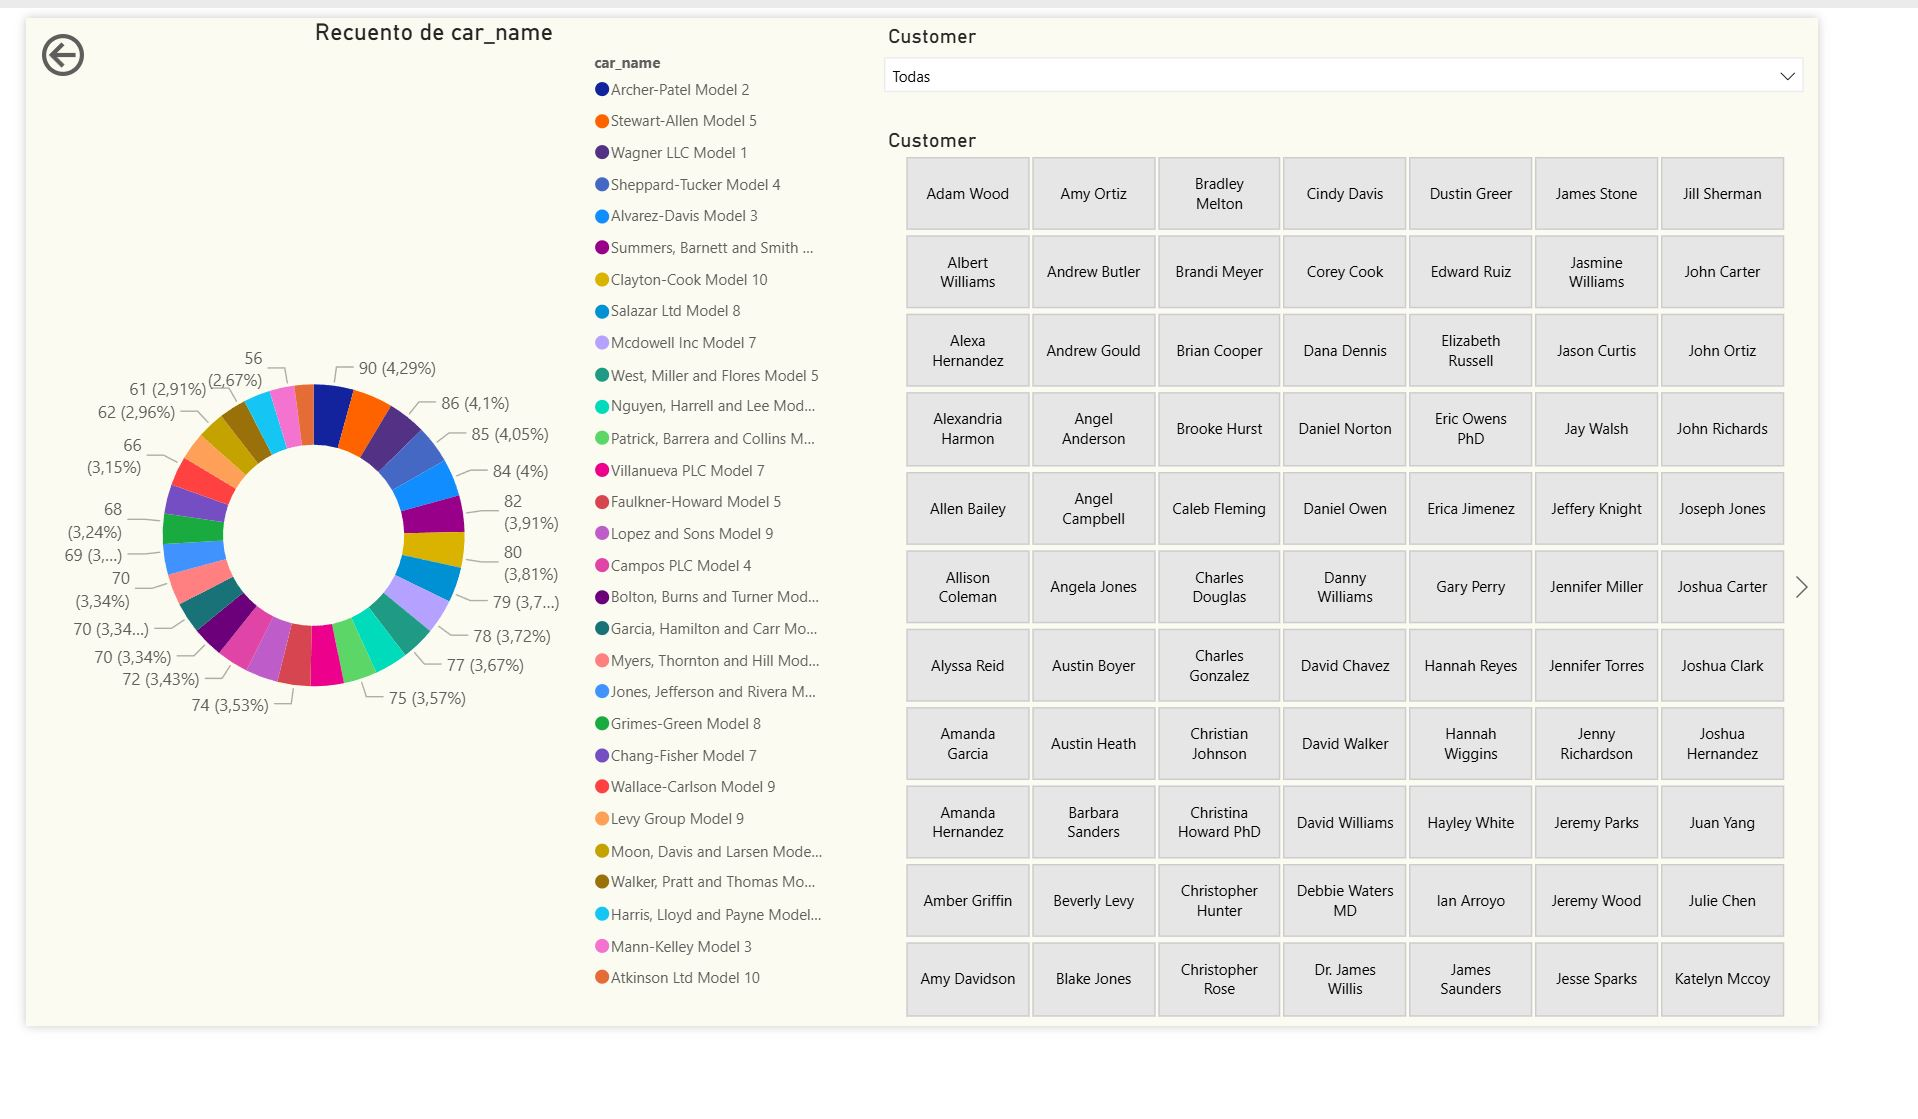

In [ ]:
sc.stop()